In [165]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D,Conv2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Reshape, multiply, MaxPooling2D
from sklearn.model_selection import train_test_split, KFold
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from datetime import datetime
import os

# server 실행
dir_path = "/home/jskwon/Desktop/projects/ongoing/NTC_SUB3/assy3d/"
os.chdir(dir_path)

In [166]:
x_lp_3d = np.load("filtered_LP_FA3D_09MAY24.npy", allow_pickle=True)
# 기존에 사용한 3d rodmap은 0과 1 사이의 값으로 mapping 한 값이 아니라 0-100 사이의 값을 24개로 복사한 값
x_rod_3d = np.load("assywise_rod_map_layers_09MAY24.npy", allow_pickle=True) 
y_p3d = np.load("filtered_FA_p3d_09MAY24.npy", allow_pickle=True)

x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(x_lp_3d,x_rod_3d, y_p3d, test_size=0.1, random_state=42)
x1_train, x1_valid, x2_train, x2_valid, y_train, y_valid = train_test_split(x1_train,x2_train, y_train, test_size=0.05, random_state=22)

In [11]:
x_lp_3d.shape, x_rod_3d.shape, y_p3d.shape

((37532, 24, 5, 5, 7), (37532, 24, 5, 5), (37532, 24, 5, 5))

In [ ]:
from tensorflow.keras.layers import Input, Conv3D, Add, Activation
from tensorflow.keras.models import Model

def residual_block_3d(input_tensor, num_filters, kernel_size):
    # First convolution
    x = layers.Conv3D(num_filters, kernel_size=kernel_size, strides=(1,1,1), padding='same')(input_tensor)
    x = layers.Activation('relu')(x)

    # Second convolution
    x = layers.Conv3D(num_filters, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(x)
    x = layers.Activation('relu')(x)

    # Shortcut path
    shortcut = layers.Conv3D(num_filters, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(input_tensor) # 1x1 합성곱으로 차원 맞춤

    # Add shortcut to output of conv layers
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

비교용

In [132]:
from tensorflow.keras.layers import Input, Conv3D, Reshape, add
from tensorflow.keras.models import Model

input1_shape = (24, 5, 5, 7) # 제어봉 포함 
input2_shape = (24, 5, 5, 1)

input_lp = Input(shape=input1_shape, name='input_lp')
input_rod = Input(shape=input2_shape, name='input_rod')

x1 = residual_block_3d(input_lp, 99, (15,5,5)) # 24, 5, 5 로 만든 후에 두개를 더하는게 낫다. 어떻게 24, 5, 5로 만들지? Good
x2 = residual_block_3d(input_rod, 99, (15,5,5) )

x1 = residual_block_3d(x1, 1, (5,5,5))
x = keras.layers.add([x1, x2])

x = residual_block_3d(x, 99, (15,3,3))
x = residual_block_3d(x, 99, (3,3,3))
x = residual_block_3d(x, 1, (3,3,3))

model = Model(inputs=[input_lp,input_rod], outputs=x)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mae')

x1_train = np.array(x1_train, dtype=np.float32)
x2_train = np.array(x2_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x1_valid = np.array(x1_valid, dtype=np.float32)
x2_valid = np.array(x2_valid, dtype=np.float32)
y_valid = np.array(y_valid, dtype=np.float32)

history = model.fit([x1_train,x2_train], y_train, epochs=150, validation_data=([x1_valid,x2_valid], y_valid))
model.save("rod3d_24DEC24_t3.h5")

Epoch 1/150
1003/1003 [==============================] - 37s 34ms/step - loss: 0.1087 - val_loss: 0.0947
Epoch 2/150
1003/1003 [==============================] - 34s 34ms/step - loss: 0.0828 - val_loss: 0.0556
Epoch 3/150
1003/1003 [==============================] - 34s 34ms/step - loss: 0.0466 - val_loss: 0.0330
Epoch 4/150
1003/1003 [==============================] - 34s 34ms/step - loss: 0.0331 - val_loss: 0.0323
Epoch 5/150
1003/1003 [==============================] - 34s 34ms/step - loss: 0.0283 - val_loss: 0.0257
Epoch 6/150
1003/1003 [==============================] - 34s 34ms/step - loss: 0.0269 - val_loss: 0.0225
Epoch 7/150
1003/1003 [==============================] - 34s 34ms/step - loss: 0.0245 - val_loss: 0.0205
Epoch 8/150
1003/1003 [==============================] - 34s 34ms/step - loss: 0.0229 - val_loss: 0.0300
Epoch 9/150
1003/1003 [==============================] - 34s 34ms/step - loss: 0.0224 - val_loss: 0.0182
Epoch 10/150
1003/1003 [==============================]

In [168]:
model = tf.keras.models.load_model('rod3d_24DEC24_t3.h5')

In [169]:
x1_test = x1_test.astype(np.float32)
x2_test = x2_test.astype(np.float32)

prediction = model.predict([x1_test,x2_test])
prediction = tf.squeeze(prediction, axis=-1)

118/118 [==============================] - 1s 11ms/step


In [123]:
prediction.shape

TensorShape([3754, 24, 5, 5])

In [170]:
prediction = np.array(prediction)

In [134]:
y_p3d.shape

(37532, 24, 5, 5)

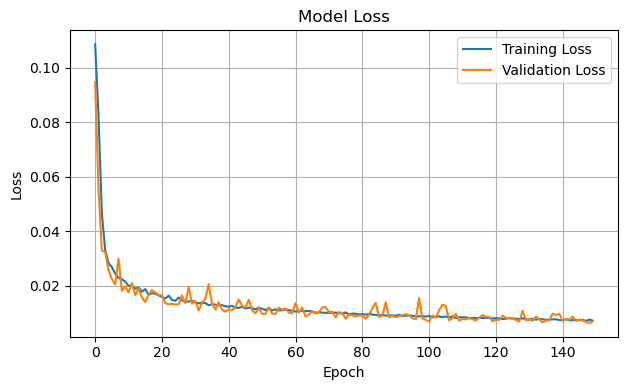

In [135]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    모델 훈련 과정의 손실과 정확도를 시각화합니다.

    Args:
        history: 모델의 fit 메서드에서 반환된 history 객체.
    """
    # 손실(loss) 시각화
    plt.figure(figsize=(12, 4))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss',) #marker='o')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss',) #marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy Plot
    if 'accuracy' in history.history:  # Keras에서 사용하는 기본 metric 이름
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

# 사용 예시
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)
plot_training_history(history)


In [136]:
import numpy as np

# prediction과 y_test는 NumPy 배열이라고 가정
# 0인 부분을 마스킹
mask = y_test != 0

# 상대 오차 계산, 마스킹된 값만 선택
percentage_error = (np.abs(prediction[mask] - y_test[mask]) / np.abs(y_test[mask])) * 100

# NaN을 제외하고 평균 계산
mean_percentage_error = np.nanmean(percentage_error)

print(f"Mean Percentage Error: {mean_percentage_error}%")


Mean Percentage Error: 0.9333823693406388%


In [137]:
import numpy as np

# 상대 오차 계산
absolute_errors = np.abs(y_test - prediction)
relative_errors = np.zeros_like(y_test, dtype=np.float64)

# 0으로 나누는 경우 방지를 위한 마스킹
nonzero_mask = y_test != 0

# 상대 오차 계산 및 NaN 처리
relative_errors[nonzero_mask] = absolute_errors[nonzero_mask] / y_test[nonzero_mask] * 100
relative_errors[np.isnan(relative_errors)] = 0  # NaN을 0으로 처리 (또는 다른 방법으로 대체)

# NaN을 제외하고 평균 상대 오차 계산
mean_relative_error = np.nanmean(relative_errors)

print("평균 상대 오차:", mean_relative_error)


평균 상대 오차: 0.821376485019762


In [249]:
import numpy as np
from numpy import ma

def optimized_error_calculation(y_test, prediction):
    # prediction이 (24, 85, 85, 1)일 경우 마지막 차원을 제거하여 (24, 85, 85)로 맞춤
    if prediction.shape[-1] == 1:
        prediction = np.squeeze(prediction, axis=-1)
    
    num_data, num_layers, num_row, num_col = y_test.shape
    
    mask = ~np.isnan(y_test) & ~np.isnan(prediction) & (y_test != 0)
    
    # 1. 오차 계산
    abs_err = np.abs(y_test - prediction)
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_err = np.where(mask, (abs_err / np.abs(y_test)) * 100, np.nan)
    
    # Nan값 마스킹 / ma는 마스킹된 값에 대한 연산
    abs_err_masked = ma.array(abs_err, mask=~mask)
    rel_err_masked = ma.array(rel_err, mask=~mask)
    #print("rel_err.shape", rel_err_masked.shape)
    #print("stdev_all_points",np.std(rel_err_masked))
    print(f"mean_all_points: {np.mean(rel_err_masked):.3f}%")
    print(f"stdev_all_points: {np.std(rel_err_masked):.3f}")
    
    # 1b) 레이어별 오차 shape: (3754, 24)
    abs_mean_err_layers = ma.mean(abs_err_masked, axis=(2, 3))
    rel_mean_err_layers = ma.mean(rel_err_masked, axis=(2, 3))

    
    abs_max_err_layers = ma.max(abs_err_masked, axis=(2, 3))
    rel_max_err_layers = ma.max(rel_err_masked, axis=(2, 3))
    
    # 1c) Voxel(core)별 오차 shape: (3754, 1)
    abs_mean_err_voxel = ma.mean(abs_mean_err_layers, axis=1)
    rel_mean_err_voxel = ma.mean(rel_mean_err_layers, axis=1)
    
    abs_max_err_voxel = ma.max(abs_max_err_layers, axis=1)
    rel_max_err_voxel = ma.max(rel_max_err_layers, axis=1)
    
    # 1d) 축방향 레이어별 누적오차 (24)
    abs_mean_err_per_layer_accumulated = ma.mean(abs_mean_err_layers, axis=0)
    rel_mean_err_per_layer_accumulated = ma.mean(rel_mean_err_layers, axis=0)
    print("rel_mean_err_layers shape", rel_mean_err_layers.shape)
    
    abs_max_err_per_layer_accumulated = ma.max(abs_max_err_layers, axis=0)
    rel_max_err_per_layer_accumulated = ma.max(rel_max_err_layers, axis=0)
    
    # 1e) 전체 오차 shape: (1)
    total_abs_mean_err = ma.mean(abs_mean_err_voxel, axis=0)
    total_rel_mean_err = ma.mean(rel_mean_err_voxel, axis=0)
    print("rel_mean_err_voxel.shape", rel_mean_err_voxel.shape)
    print("total_abs_mean_err",total_rel_mean_err )
    print(f"stdev {np.std(rel_mean_err_voxel):.3f}")
    
    total_abs_max_err = ma.max(abs_max_err_voxel, axis=0)
    total_rel_max_err = ma.max(rel_max_err_voxel, axis=0)
    
    max_of_rel_mean = ma.max(rel_mean_err_voxel, axis=0)
    mean_of_rel_max = ma.mean(rel_max_err_voxel, axis=0)
    
    # 1f) global 누적오차 shape: (24, 85, 85)
    rel_mean_err_global_accumulated = ma.mean(rel_err_masked, axis=0)
    abs_mean_err_global_accumulated = ma.mean(abs_err_masked, axis=0)

    # 2. 오차 발생 위치
    # 벡터화 연산으로 최대 오차 발생 위치 찾기
    max_err_indices = np.nanargmax(rel_err_masked.reshape(num_data, -1), axis=1)
    max_err_locations = np.column_stack(np.unravel_index(max_err_indices, (num_data, num_layers, num_row, num_col)))
    
    # True/Pred 값 및 오차율 추가
    max_err_values = rel_err_masked[tuple(max_err_locations.T)]
    true_values = y_test[tuple(max_err_locations.T)]
    pred_values = prediction[tuple(max_err_locations.T)]
    
    max_err_locations = np.column_stack((max_err_locations, true_values, pred_values, max_err_values))
    
    # 2b) Peak값 찾기
    peak_indices = np.nanargmax(y_test.reshape(num_data, -1), axis=1)
    peak_value_locations = np.column_stack(np.unravel_index(peak_indices, (num_data, num_layers, num_row, num_col)))
    
    peak_true_values = y_test[tuple(peak_value_locations.T)]
    peak_pred_values = prediction[tuple(peak_value_locations.T)]
    
    # 상대 오차 계산
    relative_errors = np.where(peak_true_values != 0, np.abs((peak_true_values - peak_pred_values) / peak_true_values) * 100, np.inf)
    
    peak_value_locations = np.column_stack((peak_value_locations, peak_true_values, peak_pred_values, relative_errors))
    
    mean_rel_err_peak = np.mean(relative_errors)
    max_rel_err_peak = np.max(relative_errors)
    
    mean_abs_err_peak = np.mean(np.abs(peak_true_values - peak_pred_values))
    max_abs_err_peak = np.max(np.abs(peak_true_values - peak_pred_values))

    return (abs_mean_err_layers, rel_mean_err_layers, abs_max_err_layers, rel_max_err_layers,
            abs_mean_err_voxel, rel_mean_err_voxel, abs_max_err_voxel, rel_max_err_voxel,
            total_abs_mean_err, total_rel_mean_err, total_abs_max_err, total_rel_max_err,
            max_err_locations, peak_value_locations, mean_rel_err_peak, max_rel_err_peak, mean_abs_err_peak, max_abs_err_peak,
            rel_mean_err_per_layer_accumulated,abs_mean_err_per_layer_accumulated, rel_max_err_per_layer_accumulated,
            rel_mean_err_global_accumulated, abs_mean_err_global_accumulated, max_of_rel_mean, mean_of_rel_max)

# 결과 계산
results = optimized_error_calculation(y_test, prediction)

# 결과 변수 할당
(abs_mean_err_layers, rel_mean_err_layers, abs_max_err_layers, rel_max_err_layers,
 abs_mean_err_voxel, rel_mean_err_voxel, abs_max_err_voxel, rel_max_err_voxel,
 total_abs_mean_err, total_rel_mean_err, total_abs_max_err, total_rel_max_err,
 max_err_locations, peak_value_locations, mean_rel_err_peak, max_rel_err_peak,mean_abs_err_peak,max_abs_err_peak,
 rel_mean_err_per_layer_accumulated, abs_mean_err_per_layer_accumulated, rel_max_err_per_layer_accumulated,
 rel_mean_err_global_accumulated, abs_mean_err_global_accumulated,  max_of_rel_mean, mean_of_rel_max) = results

# 결과 출력
print("--------Relative Errors--------")
print(f"Global mean relative error(%): {total_rel_mean_err:.3f}%")
print(f"std: {np.std(rel_mean_err_voxel):.3f}")
#print(f"Max of mean relative error (%): {max_of_rel_mean:.3f}")
print(f"Global max relative error(%): {total_rel_max_err:.3f}%")
#print(f"Mean of max relative error (%): {mean_of_rel_max:.3f}")
print(f"Global mean relative Peak Error (%): {mean_rel_err_peak:.3f}%")
print(f"Global max relative Peak Error (%): {max_rel_err_peak:.3f}%")
print("                                 ")
print("--------Absolute Errors--------")
print(f"Global mean absolute error: {total_abs_mean_err:.3f}")
print(f"Global max absolute error: {total_abs_max_err:.3f}")
print(f"Global mean absolute Peak Error: {mean_abs_err_peak:.3f}")
print(f"Global max absolute Peak Error: {max_abs_err_peak:.3f}")



mean_all_points: 0.933%
stdev_all_points: 1.057
rel_mean_err_layers shape (3754, 24)
rel_mean_err_voxel.shape (3754,)
total_abs_mean_err 0.9333823710402958
stdev 0.348
--------Relative Errors--------
Global mean relative error(%): 0.933%
std: 0.348
Global max relative error(%): 39.684%
Global mean relative Peak Error (%): 0.572%
Global max relative Peak Error (%): 2.384%
                                 
--------Absolute Errors--------
Global mean absolute error: 0.008
Global max absolute error: 0.373
Global mean absolute Peak Error: 0.012
Global max absolute Peak Error: 0.052


In [ ]:
prediction.shape


In [ ]:
prediction[0,0,:,:]

In [ ]:
y_test[0,0,:,:]

In [ ]:
a = (abs(y_test[0,0,:,:] - prediction[0,0,:,:])/y_test[0,0,:,:])*100
a

In [ ]:
b = (abs(y_test[0,5,:,:] - prediction[0,5,:,:])/y_test[0,5,:,:])*100
b

In [ ]:
c = (abs(y_test[0,23,:,:] - prediction[0,23,:,:])/y_test[0,23,:,:])*100
c

In [ ]:
for 

결과 저장

In [19]:
np.save("y_test_RodMap_type1_24JUN24_t1_kernel555.npy",y_test)
np.save("prediction_RodMap_type1_24JUN24_t1_kernel555.npy",prediction)

### 오차 플롯

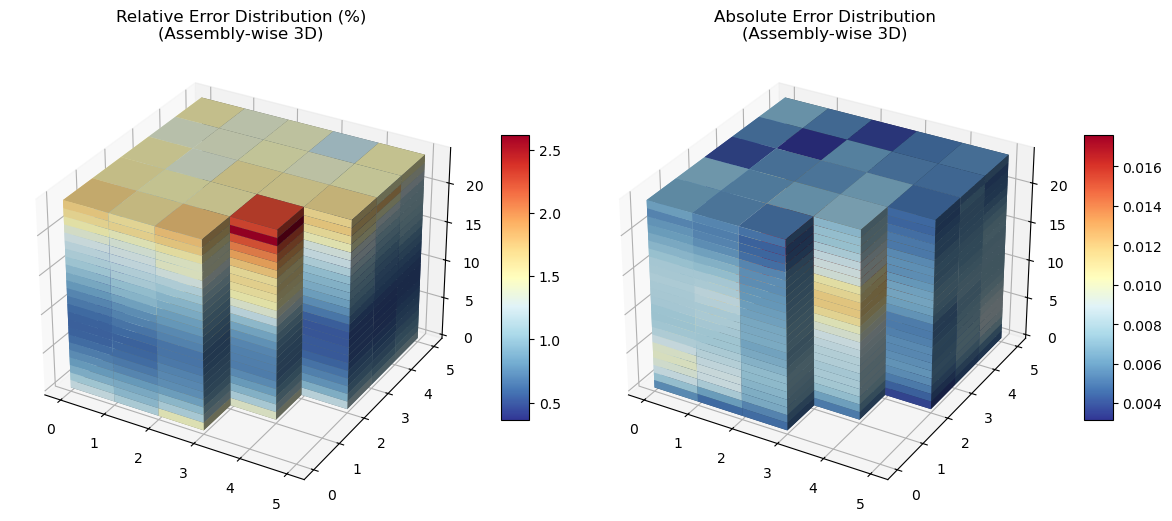

In [225]:
import matplotlib.pyplot as plt
import numpy as np

# 샘플 데이터 (여기에 주어진 데이터를 넣어야 함)
rel_data = rel_mean_err_global_accumulated.transpose(2, 1, 0)  # shape: (5, 5, 24)
abs_data = abs_mean_err_global_accumulated.transpose(2, 1, 0)

# 상하 반전 및 전처리
rel_data = rel_data[:, ::-1, ::-1]  # 상대오차
abs_data = abs_data[:, ::-1, ::-1]  # 절대오차

# 사용할 컬러맵
cmap = plt.cm.RdYlBu_r

# Plot 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

# 상대오차 플롯
ax1 = axes[0]
rel_norm = plt.Normalize(rel_data.min(), rel_data.max())
rel_colors = np.empty(rel_data.shape, dtype=object)
for i in range(rel_data.shape[0]):
    for j in range(rel_data.shape[1]):
        for k in range(rel_data.shape[2]):
            rel_colors[i, j, k] = cmap(rel_norm(rel_data[i, j, k]))

rel_threshold = 1e-10
rel_voxels = rel_data > rel_threshold

ax1.voxels(rel_voxels, facecolors=rel_colors, edgecolor=None)
mappable_rel = plt.cm.ScalarMappable(cmap=cmap, norm=rel_norm)
fig.colorbar(mappable_rel, ax=ax1, shrink=0.5, aspect=10)
ax1.set_title("Relative Error Distribution (%)\n(Assembly-wise 3D)")

# 절대오차 플롯
ax2 = axes[1]
abs_norm = plt.Normalize(abs_data.min(), abs_data.max())
abs_colors = np.empty(abs_data.shape, dtype=object)
for i in range(abs_data.shape[0]):
    for j in range(abs_data.shape[1]):
        for k in range(abs_data.shape[2]):
            abs_colors[i, j, k] = cmap(abs_norm(abs_data[i, j, k]))

abs_threshold = 1e-10
abs_voxels = abs_data > abs_threshold

ax2.voxels(abs_voxels, facecolors=abs_colors, edgecolor=None)
mappable_abs = plt.cm.ScalarMappable(cmap=cmap, norm=abs_norm)
fig.colorbar(mappable_abs, ax=ax2, shrink=0.5, aspect=10)
ax2.set_title("Absolute Error Distribution\n(Assembly-wise 3D)")

# 공통 설정
plt.tight_layout()
plt.show()


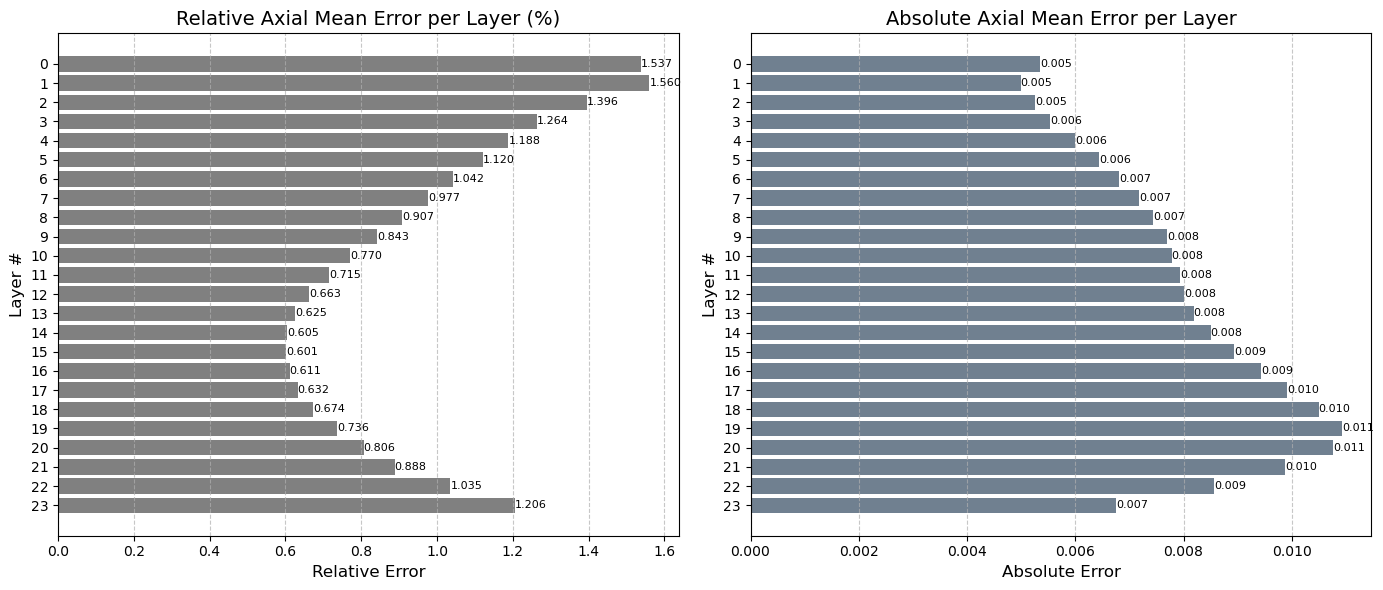

In [220]:
import matplotlib.pyplot as plt

# 샘플 데이터 (여기에 데이터를 입력해야 합니다)
depths = range(len(rel_mean_err_per_layer_accumulated)-1, -1, -1)

# 1행 2열 플롯 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 상대오차 그래프
ax1 = axes[0]
bars1 = ax1.barh(depths, rel_mean_err_per_layer_accumulated, color='gray')
ax1.set_title('Relative Axial Mean Error per Layer (%)', fontsize=14)
ax1.set_xlabel('Relative Error', fontsize=12)
ax1.set_ylabel('Layer #', fontsize=12)
ax1.set_yticks(depths)
ax1.set_yticklabels(range(len(rel_mean_err_per_layer_accumulated)))

# 각 막대에 값 표시 (상대오차)
for i, v in enumerate(rel_mean_err_per_layer_accumulated):
    ax1.text(v, len(rel_mean_err_per_layer_accumulated)-1-i, f'{v:.3f}', va='center', fontsize=8)

ax1.grid(axis='x', linestyle='--', alpha=0.7)

# 절대오차 그래프
ax2 = axes[1]
bars2 = ax2.barh(depths, abs_mean_err_per_layer_accumulated, color='slategrey')
ax2.set_title('Absolute Axial Mean Error per Layer', fontsize=14)
ax2.set_xlabel('Absolute Error', fontsize=12)
ax2.set_ylabel('Layer #', fontsize=12)
ax2.set_yticks(depths)
ax2.set_yticklabels(range(len(abs_mean_err_per_layer_accumulated)))

# 각 막대에 값 표시 (절대오차)
for i, v in enumerate(abs_mean_err_per_layer_accumulated):
    ax2.text(v, len(abs_mean_err_per_layer_accumulated)-1-i, f'{v:.3f}', va='center', fontsize=8)

ax2.grid(axis='x', linestyle='--', alpha=0.7)

# 전체 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()


In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_multiple_2d_data(data):
    num_plots = data.shape[0]
    fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(10, 8))  # 4x6 subplot grid
    
    cmap = plt.cm.RdGy_r
    vmin = np.min(data)  # Minimum value across all layers
    vmax = np.max(data)  # Maximum value across all layers
    
    # Plotting each layer
    for i in range(num_plots):
        row = i // 6
        col = i % 6
        ax = axes[row, col]
        
        im = ax.imshow(data[i], cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
        
        # Adjust the title format to represent "top of the core" and "bottom of the core"
        if i == 0:
            ax.set_title('Top of the core: Layer 0')
        elif i == 23:
            ax.set_title('Bottom of the core: Layer 23')
        else:
            ax.set_title(f'{i}')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Add a colorbar that shares intensity scale for all layers
    #fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', label='Intensity')
    
    fig.suptitle('Relative Mean Error per Layer (%)', fontsize=18)
    
    #fig.text(0.5, 0.95, 'Subtitle Line 1\nSubtitle Line 2', ha='center', va='top', fontsize=12)
    plt.tight_layout(pad=2.0, w_pad=1.0, h_pad=1.0) 
    plt.show()

# 예시 데이터 생성 (24, 5, 5) 형태 (사용자 데이터 대신 예시 데이터 사용)
data2 = rel_mean_err_global_accumulated   # 예시 데이터 (24 layers, each of shape 5x5)
#data2 = abs_mean_err_global_accumulated
#data2 = rel_mean_err_global_accumulated.transpose(2, 1, 0)
#data_reversed = data2[:, ::-1, :] 

# 데이터 플롯 함수 호출
plot_multiple_2d_data(data2)


NameError: name 'rel_mean_err_global_accumulated' is not defined

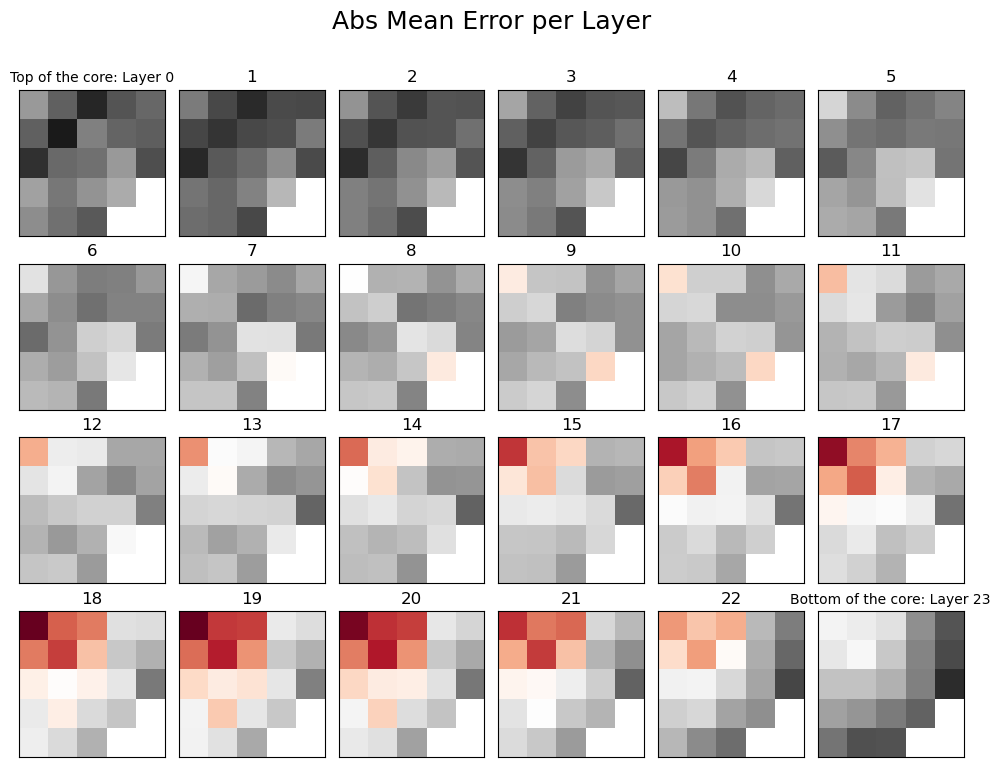

In [218]:
import matplotlib.pyplot as plt
import numpy as np

def plot_multiple_2d_data(data):
    num_plots = data.shape[0]
    fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(10, 8))  # 4x6 subplot grid
    
    #cmap = plt.cm.RdYlBu_r
    cmap = plt.cm.RdGy_r
    vmin = np.min(data)  # Minimum value across all layers
    vmax = np.max(data)  # Maximum value across all layers
    
    # Plotting each layer
    for i in range(num_plots):
        row = i // 6
        col = i % 6
        ax = axes[row, col]
        
        im = ax.imshow(data[i], cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
        
        # Adjust the title format to represent "top of the core" and "bottom of the core"
        if i == 0:
            ax.set_title('Top of the core: Layer 0', fontsize=10)
        elif i == 23:
            ax.set_title('Bottom of the core: Layer 23', fontsize=10)
        else:
            ax.set_title(f'{i}')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Add a colorbar that shares intensity scale for all layers
    #fig.colorbar(im, ax=axes.ravel().tolist(), orientation='horizontal', label='Intensity')
    
    fig.suptitle('Abs Mean Error per Layer', fontsize=18)
    
    #fig.text(0.5, 0.95, 'Subtitle Line 1\nSubtitle Line 2', ha='center', va='top', fontsize=12)
    plt.tight_layout(pad=2.0, w_pad=1.0, h_pad=1.0) 
    plt.show()

# 예시 데이터 생성 (24, 5, 5) 형태 (사용자 데이터 대신 예시 데이터 사용)
#data2 = rel_mean_err_global_accumulated   # 예시 데이터 (24 layers, each of shape 5x5)
data3 = abs_mean_err_global_accumulated
#data2 = rel_mean_err_global_accumulated.transpose(2, 1, 0)
#data_reversed = data2[:, ::-1, :] 

# 데이터 플롯 함수 호출
plot_multiple_2d_data(data3)
